# Load Forecasting: Taiwan Industry


In [2]:
import time
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [4]:
from utils.metrics import evaluate
from utils.plot import show_history, show_error

## Data Processing


In [5]:
# step setting
past_steps = 7
future_steps = 7

# date range setting
train_from, train_to = '2017-01-05', '2018-12-26'
valid_from, valid_to = '2019-01-06', '2019-09-28'

# defining features
features = ['peak_load_shift7', 'is_holiday_shift7', 'day_of_year', 'week_update_shift7', 'temp_taipei_shift7']

# defining target
target = ['power_consumption']

In [6]:
data = pd.read_csv('data/taiwan_industrial_electricity_processed_20160101_20190930.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [7]:
# data range selection
train = data[(data['date'] >= train_from) & (data['date'] <= train_to)]
valid = data[(data['date'] >= valid_from) & (data['date'] <= valid_to)]

In [ ]:
# normalization
feature_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train[features])
target_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train[target])
train.loc[:, features] = feature_scaler.transform(train.loc[:, features])
train.loc[:, target] = target_scaler.transform(train.loc[:, target])
valid.loc[:, features] = feature_scaler.transform(valid.loc[:, features])
valid.loc[:, target] = target_scaler.transform(valid.loc[:, target])

## Modelling & Training


In [9]:
def get_train_set(train, target, features, past_steps, future_steps):
    """get train set for lstm model
    Args:
        train: pd.DataFrame, train set
        target: list, target columns
        features: list, feature columns
        past_steps: int, past steps by day
        future_steps: int, future steps by day
        
    Returns:
        train_x: np.array, train set for x
        train_y: np.array, train set for y
        train_i: pd.DataFrame, train set for index
    """
    train_x, train_y, train_i = [], [], []
    for i in range(past_steps, len(train) - future_steps):
        train_x.append(train[i - past_steps:i][features])
        train_y.append(train[i:i + future_steps][target])
        train_i.append(train[i:i + future_steps])
    train_x = np.array(train_x)
    train_y = np.array(train_y)
    train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], train_x.shape[2])
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    train_i = pd.concat(train_i, axis=0).reset_index(drop=True)
    return train_x, train_y, train_i

In [10]:
def get_valid_set(valid, target, features, past_steps, future_steps):
    """get valid set for prediction
    
    Args:
        valid: pd.DataFrame, valid set
        target: list, target columns
        features: list, feature columns
        past_steps: int, past steps by day
        future_steps: int, future steps by day
    
    Returns:
        valid_x: np.array, valid set for x
        valid_y: np.array, valid set for y
        valid_i: pd.DataFrame, valid set for index
    """
    valid_x, valid_y, valid_i = [], [], []
    for i in range(0, int((valid.shape[0] - past_steps) / future_steps)):
        valid_x.append(valid[future_steps * i:future_steps * i + past_steps][features])
        valid_y.append(valid[future_steps * i + past_steps:future_steps * (i + 1) + past_steps][target]) 
        valid_i.append(valid[future_steps * i + past_steps:future_steps * (i + 1) + past_steps])
    valid_x = np.array(valid_x)
    valid_y = np.array(valid_y)
    valid_x = valid_x.reshape(valid_x.shape[0], valid_x.shape[1], valid_x.shape[2])
    valid_y = valid_y.reshape(valid_y.shape[0], valid_y.shape[1], 1)
    valid_i = pd.concat(valid_i, axis=0).reset_index(drop=True)
    return valid_x, valid_y, valid_i

In [11]:
def get_model(x_shape, y_shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=200, input_shape=(x_shape[1], x_shape[2])))
    model.add(tf.keras.layers.RepeatVector(y_shape[1]))
    model.add(tf.keras.layers.LSTM(units=200, return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(200, activation='relu')))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    return model

In [12]:
# data packaging for training
train_x, train_y, train_i = get_train_set(train, target, target + features, past_steps, future_steps)
valid_x, valid_y, valid_i = get_valid_set(valid, target, target + features, past_steps, future_steps)
print("train_x.shape", train_x.shape, "train_y.shape", train_y.shape)
print("valid_x.shape", valid_x.shape, "valid_y.shape", valid_y.shape)

train_x.shape (707, 7, 6) train_y.shape (707, 7, 1)
valid_x.shape (37, 7, 6) valid_y.shape (37, 7, 1)


To measure the model fairly, train n models.


In [14]:
# [100, 300, 500, 1000]
EPOCHS = 500

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 16

# Define model name
MODEL_NAME = F"Power Consumption LSTM {train_x.shape[1]}to{train_y.shape[1]} Epochs{EPOCHS} Batch{BATCH_SIZE}"

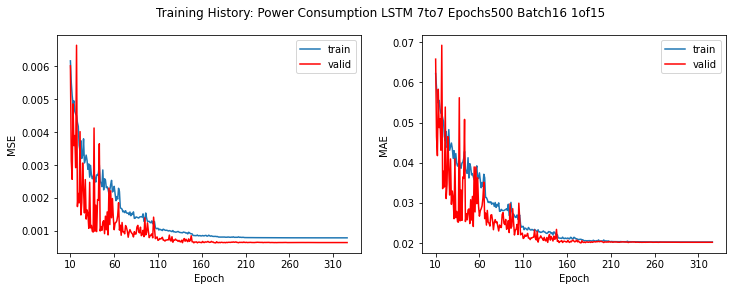

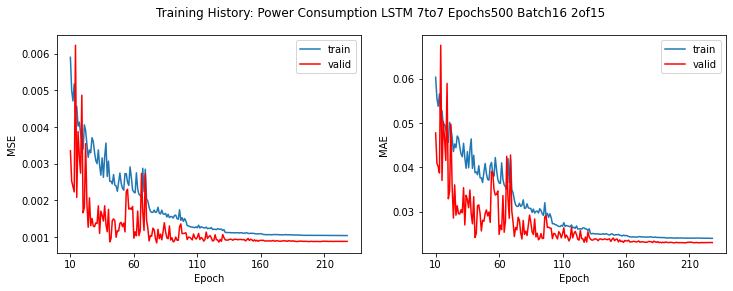

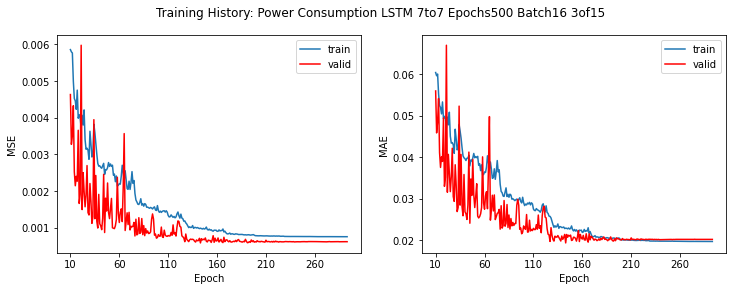

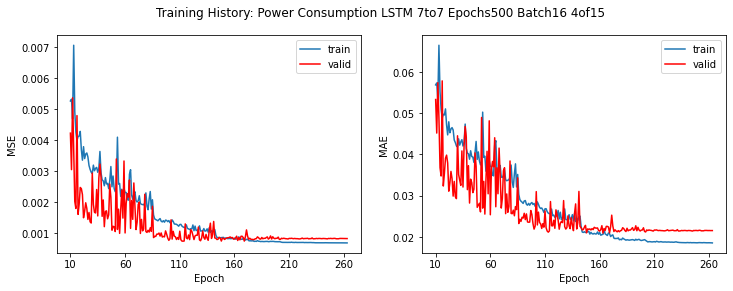

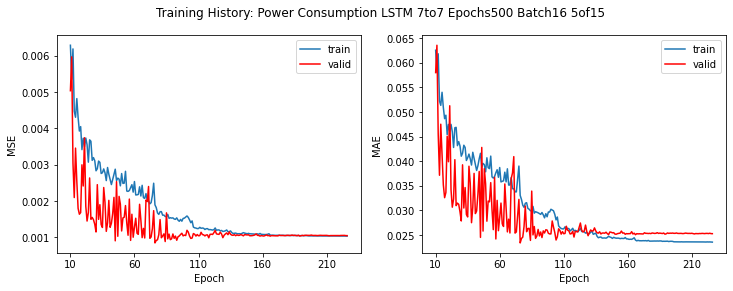

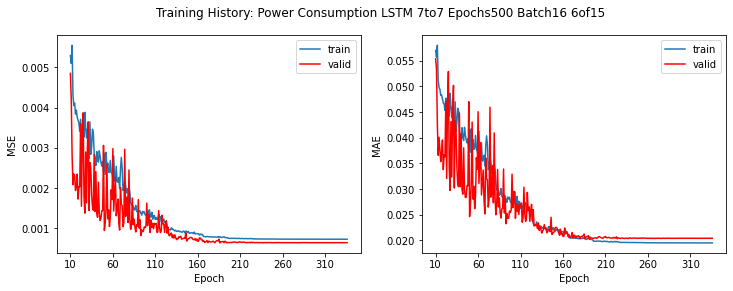

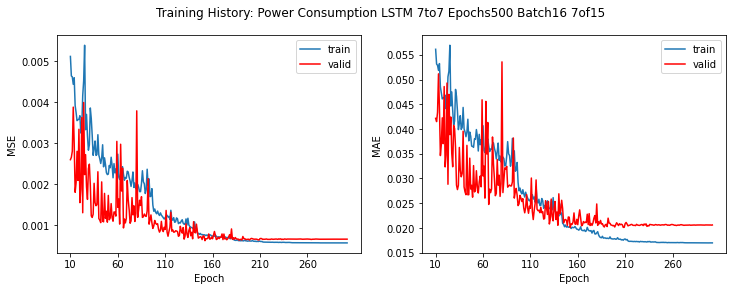

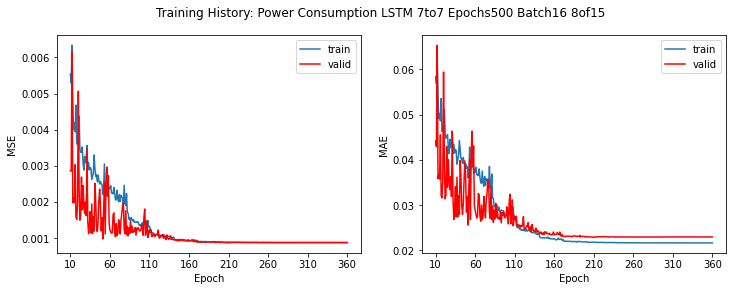

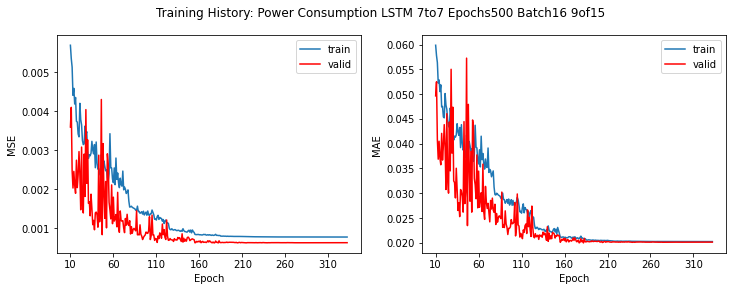

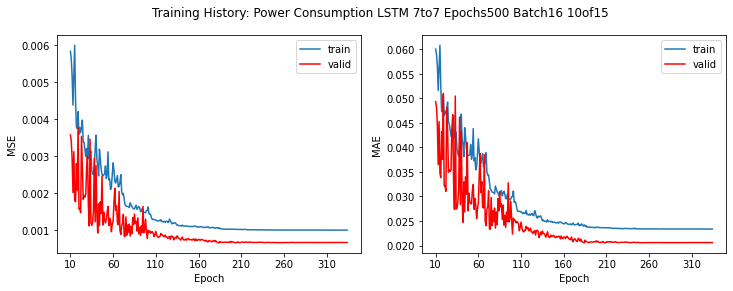

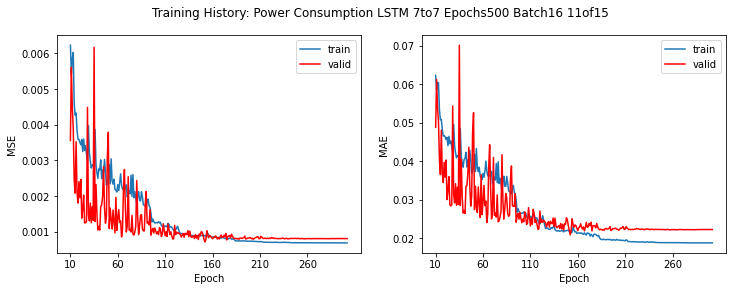

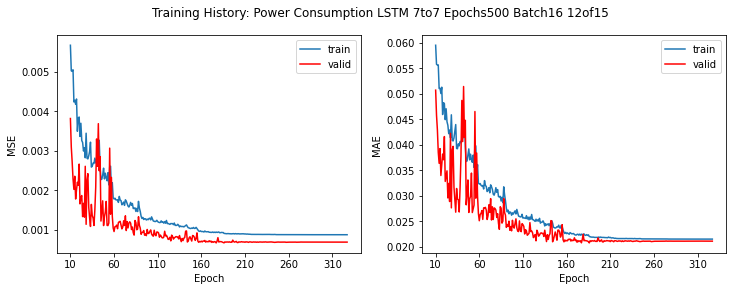

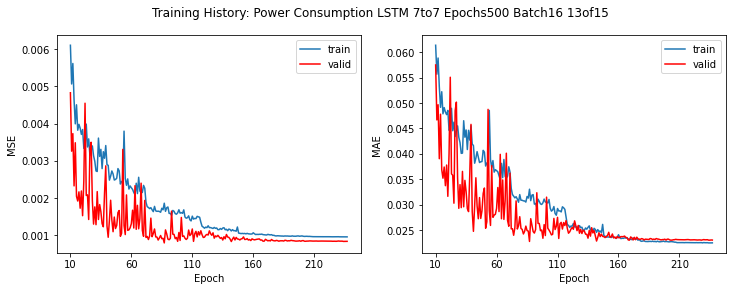

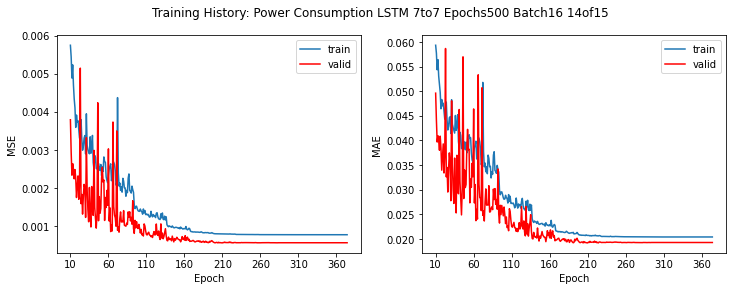

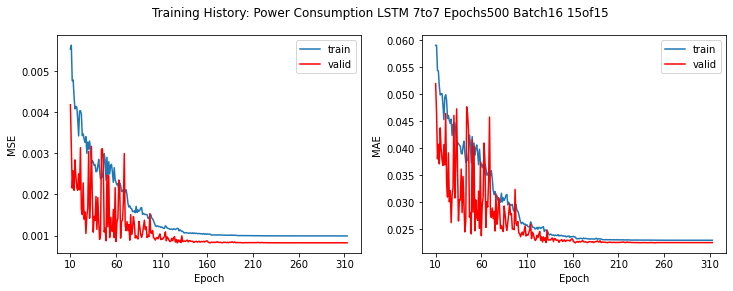

1474.010511636734


In [22]:
start = time.time()

# Train model
for i in range(15):
    model = get_model(train_x.shape, train_y.shape)

    # Train model
    history = model.fit(
        train_x, train_y,
        epochs=EPOCHS, batch_size=BATCH_SIZE,
        verbose=0,
        validation_split=0.1,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(F"models/{MODEL_NAME.lower().replace(' ', '_')}_{i+1}of{15}.h5", save_best_only=True, save_weights_only=True, mode='min'),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=30, mode='min', verbose=0),
            tf.keras.callbacks.EarlyStopping(patience=150, mode="min", restore_best_weights=True)
        ]
    )

    # Save history
    history = pd.DataFrame(history.history)
    history.to_csv(F"logs/{MODEL_NAME.lower().replace(' ', '_')}_{i+1}of{15}.csv", index=False)
    show_history(history, F"{MODEL_NAME} {i+1}of{15}", 10)

end = time.time()
print(format(end-start))

## Prediction


In [ ]:
valid_y_pred_list = []

for i in range(15):
    model = get_model(train_x.shape, train_y.shape)
    model.load_weights(F"models/{MODEL_NAME.lower().replace(' ', '_')}_{i+1}of{15}.h5")
    
    valid_y_pred = model.predict(valid_x)
    valid_y_pred = valid_y_pred.reshape(valid_y_pred.shape[0], -1)
    valid_y_pred = target_scaler.inverse_transform(valid_y_pred)
    valid_y_pred_list.append(valid_y_pred)
    
valid_y_pred_avg = np.array(valid_y_pred_list).mean(axis=0)

In [ ]:
def show_error(real, pred, index, title):
    plt.figure(figsize=(12, 4))
    plt.plot(index, real, color='red', label='Real')
    plt.plot(index, pred, color='blue', label='Pred')
    plt.title(F"Power Consumption Prediction: {title}")
    plt.ylabel('Power Consumption (MkWh)')
    plt.legend()
    plt.savefig(F"results/{title.lower().replace(' ', '_')}.jpg", bbox_inches='tight', pad_inches=0.05)
    plt.show()

RMSE 7.959144932889191
MAPE 1.893387947046521


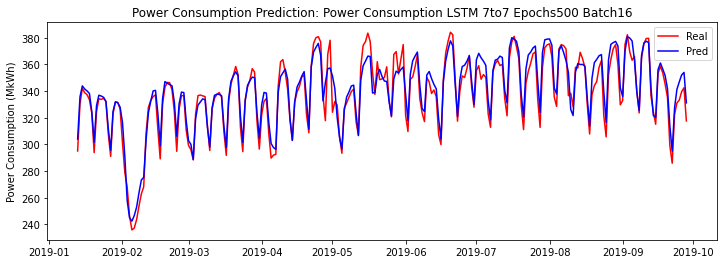

In [16]:
valid_y_inverse = valid_y.reshape(valid_y.shape[0], -1)
valid_y_inverse = target_scaler.inverse_transform(valid_y_inverse)
evaluate(valid_y_inverse.flatten(), valid_y_pred_avg.flatten())
show_error(valid_y_inverse.flatten(), valid_y_pred_avg.flatten(), valid_i['date'].values, MODEL_NAME)